# Pretrained Models

One of the most powerful features of Deep Learning is the use of a Pre-Trained model. There are a few key reasons we want to use these instead of building our own:
- **Small Data Problem**: Often the problem we are trying to solve can be very niche with small datasets. If we attempt to train a model from scratch, our model will tend to overfit the data very quickly!
- **Compute Savings**: It is no secret that deep learning is a very computationally expensive task. Often when using a pretrained model we will not allow a part of the model to accept any gradient updates, therefore reducing considerably the computation needed
- **Predefined Architectures**: Having a deep understanding of complex architectures and being able to implement them is crucial, but using predifined architectures will remove some of those burderns and let you focus on model testing. 

In [1]:
### IMPORT MODULES ###
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, Resize, ToTensor
from torchsummary import summary
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### HUGGINGFACE ###
import transformers
import datasets
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

print("HuggingFace Transformers Version:", transformers.__version__)
print("HuggingFace Datasets Version:", datasets.__version__)
print("PyTorch Version:", torch.__version__)

HuggingFace Transformers Version: 4.25.1
HuggingFace Datasets Version: 2.7.0
PyTorch Version: 1.13.1+cu117


# Cats vs Dogs

We will be training a model that can differentiate between Cats and Dogs. We will do this by:
- Train a ResNet18 from scratch 
- Finetune a Pretrained ResNet18
- Leverage the Huggingface API to perform finetuning

## Vanilla PyTorch

In [2]:
### Build Cats vs Dogs Dataset ###
PATH_TO_DATA = "data/dogsvcats"
dataset = ImageFolder(PATH_TO_DATA)

### DEFINE TRANSFORMATIONS ###
normalizer = Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) ### IMAGENET MEAN/STD ###
train_transforms = Compose([
            Resize((224,224)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalizer])

val_transforms = Compose([
            Resize((224,224)),
            ToTensor(),
            normalizer])


train_samples, test_samples = int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths=[train_samples, test_samples])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

### Randomly Initialized Model

In [3]:
### SELECT DEVICE ###
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on Device {DEVICE}")

### LOAD IN and Modify RESNET18 Model ###
model = resnet18(weights=None)
model.fc = nn.Linear(in_features=512, out_features=2)
model = model.to(DEVICE)

### MODEL TRAINING INPUTS ###
epochs = 5
optimizer = optim.AdamW(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

### BUILD DATALOADERS ###
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

def train(model, device, epochs, optimizer, loss_fn, batch_size, trainloader, valloader):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []

        for image, label in tqdm(trainloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            optimizer.zero_grad()
            out = model.forward(image)

            ### CALCULATE LOSS ##
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            ### CALCULATE ACCURACY ###
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            training_accuracies.append(accuracy.item())

            loss.backward()
            optimizer.step()

        for image, label in tqdm(valloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            with torch.no_grad():
                out = model.forward(image)

                ### CALCULATE LOSS ##
                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

                ### CALCULATE ACCURACY ###
                predictions = torch.argmax(out, axis=1)
                accuracy = (predictions == label).sum() / len(predictions)
                validation_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean) 
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)
        
    return log_training, model
        
random_init_logs, model = train(model=model,
                                device=DEVICE,
                                epochs=5,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                batch_size=batch_size,
                                trainloader=trainloader,
                                valloader=valloader)

Training on Device cuda
Starting Epoch 1


100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Training Loss: 0.6386803317476403
Training Acc: 0.6360795453868129
Validation Loss: 0.5728394329547882
Validation Acc: 0.7069623172283173
Starting Epoch 2


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


Training Loss: 0.5190770837732337
Training Acc: 0.7412801845507189
Validation Loss: 0.4774676740169525
Validation Acc: 0.7795496314764023
Starting Epoch 3


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Training Loss: 0.44207071750001475
Training Acc: 0.7974289770830761
Validation Loss: 0.4204742893576622
Validation Acc: 0.81484375
Starting Epoch 4


100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


Training Loss: 0.37033714210106566
Training Acc: 0.8358132100918076
Validation Loss: 0.33932512775063517
Validation Acc: 0.8513786762952804
Starting Epoch 5


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]

Training Loss: 0.29492924675684085
Training Acc: 0.8737801845100793
Validation Loss: 0.2998258762061596
Validation Acc: 0.8730009198188782


### PreTrained Model

In [4]:
### LOAD IN PRETRAINED MODEL ###
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(in_features=512, out_features=2)
model = model.to(DEVICE)

### RELOAD OPTIMIZER ###
optimizer = optim.AdamW(params=model.parameters())

pretrained_init_logs, model = train(model=model,
                                    device=DEVICE,
                                    epochs=2,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    batch_size=batch_size,
                                    trainloader=trainloader,
                                    valloader=valloader)

Starting Epoch 1


100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Training Loss: 0.11009281108536842
Training Acc: 0.954984019764445
Validation Loss: 0.09738074820488692
Validation Acc: 0.9610983461141587
Starting Epoch 2


100%|██████████| 20/20 [00:02<00:00,  7.06it/s]

Training Loss: 0.06403895856452767
Training Acc: 0.973918678746982
Validation Loss: 0.08295177668333054
Validation Acc: 0.9674172788858414


## Frozen Encoder Pretrained Model

In [5]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(in_features=512, out_features=2)
model.to(DEVICE)

# summary(model, input_size=(3,224,224))

for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad_(False)
        
summary(model, input_size=(3,224,224))
### RELOAD OPTIMIZER ###
optimizer = optim.AdamW(params=model.parameters())

frozen_pretrained_logs, model = train(model=model,
                                      device=DEVICE,
                                      epochs=2,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      batch_size=batch_size,
                                      trainloader=trainloader,
                                      valloader=valloader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


Training Loss: 0.14813876414502208
Training Acc: 0.9485671164637263
Validation Loss: 0.08608611971139908
Validation Acc: 0.9730238974094391
Starting Epoch 2


100%|██████████| 20/20 [00:02<00:00,  7.27it/s]

Training Loss: 0.07642080932220613
Training Acc: 0.9728657667609778
Validation Loss: 0.05928442077711225
Validation Acc: 0.9814797788858414


## HuggingFace
Huggingface offers connectors into state-of-the-art models in a simple way! It is especially easy to access pretrained models, but we will see how to use their trainer to fine tune our own models!

### Benefits of the Huggingface Platform
- Access to state of the art models in all domains (Vision, Speech, NLP, etc...) with uniform methodology
- Easy access to Distributed Training (**Huggingface Accelerate**)
- Distributed Hyperparameter Tuning

### Load model with frozen encoder and set output size

In [6]:
### LOAD EXTRACTOR AND MODEL ###
huggingface_resnet_18 = "microsoft/resnet-18"

id2label = {"0": "cat",
            "1": "dog"}

label2id = {"cat": "0",
            "dog": "1"}

model = AutoModelForImageClassification.from_pretrained(huggingface_resnet_18,
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True)

### Comment out if you want to train the full model 
for name, param in model.resnet.named_parameters():
    param.requires_grad_(False)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Huggingface Datasets

Huggingface offers many datasets built into their platform, but we want to use our own custom dataset. Luckily they offer the same imagefolder method given from PyTorch so we can rebuild our CatsvDog dataset without much extra work

In [7]:
### LOAD DATASET AND METRIC ###
dataset = load_dataset("imagefolder", data_dir=PATH_TO_DATA)
metrics = load_metric("accuracy")

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Using custom data configuration default-89a288c3f3c44ebf
Found cached dataset imagefolder (/home/priyammazumdar/.cache/huggingface/datasets/imagefolder/default-89a288c3f3c44ebf/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-7-d4951fe84ebe>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = load_metric("accuracy")


### Access an image from Huggingface Dataset

dog


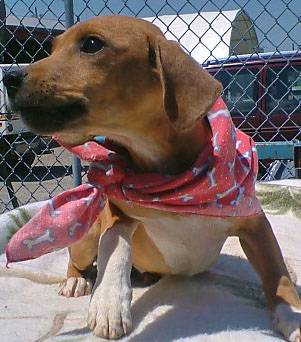

In [8]:
idx = 20000
single_sample = dataset["train"][idx]
print("cat" if single_sample["label"] == 0 else "dog")
single_sample["image"]

### Seperate Data into Training and Validation ###
Once our data is split, we need to apply transformations to it, to do so, we need to make some quick helper functions to apply our transformations for each image

In [9]:
split_dataset = dataset["train"].train_test_split(test_size=0.1, shuffle=True, seed=0)
train_dataset, val_dataset = split_dataset["train"], split_dataset["test"]

### Use same transformations from before
def train_transformation(data_dict):
    data_dict["pixel_values"] = [train_transforms(image) for image in data_dict["image"]]
    return data_dict

def val_transformation(data_dict):
    data_dict["pixel_values"] = [val_transforms(image) for image in data_dict["image"]]
    return data_dict

train_dataset.set_transform(train_transformation)
val_dataset.set_transform(val_transformation)

Loading cached split indices for dataset at /home/priyammazumdar/.cache/huggingface/datasets/imagefolder/default-89a288c3f3c44ebf/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-24cdfd4aab52ea59.arrow and /home/priyammazumdar/.cache/huggingface/datasets/imagefolder/default-89a288c3f3c44ebf/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-e57fabaa2464c4f4.arrow


### Build Trainer Arguments

In [10]:
args = TrainingArguments(
    "huggingface_resnet18",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=128,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

### Track Metrics
Because we are going to be training in batches, the metrics we decided (accuracy) has to be applied to each batch. To do this we need a quick helper function

In [11]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metrics.compute(predictions=predictions, references=eval_pred.label_ids)

### Prep which data is pass

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### Instantiate and Run Trainer ###

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

train_results = trainer.train()

/home/priyammazumdar/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 22500
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 2
  Total optimization steps = 132
  Number of trainable parameters = 1026
/home/priyammazumdar/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.354900,0.259294,0.939600
2,0.167000,0.144360,0.961200
3,0.139500,0.130814,0.963600


***** Running Evaluation *****
  Num examples = 2500
  Batch size = 128
Saving model checkpoint to huggingface_resnet18/checkpoint-44
Configuration saved in huggingface_resnet18/checkpoint-44/config.json
Model weights saved in huggingface_resnet18/checkpoint-44/pytorch_model.bin
/home/priyammazumdar/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 128
Saving model checkpoint to huggingface_resnet18/checkpoint-88
Configuration saved in huggingface_resnet18/checkpoint-88/config.json
Model weights saved in huggingface_resnet18/checkpoint-88/pytorch_model.bin
/home/priyammazumdar/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gath